In [1]:
%load_ext autoreload
%autoreload 2

# Market Regime Detection Analysis

## Introduction

Market regimes refer to distinct periods during which the statistical properties of asset returns (like mean, volatility, and correlation) behave differently. Identifying these regimes is crucial for dynamic asset allocation, risk management, and strategy development. For example, a portfolio might perform well in a "Bull" regime but poorly in a "Bear" regime.

This notebook walks through the process of detecting market regimes for a portfolio of European assets using techniques like Hidden Markov Models (HMM) and K-means clustering. We will analyze:

1.  **Market Regimes:** Using HMM on asset returns to identify periods like Bull, Bear, or Sideways markets.
2.  **Volatility Regimes:** Using K-means clustering on volatility measures to identify periods of Low, Medium, or High volatility.
3.  **Correlation Regimes:** Using K-means clustering on rolling average correlations to identify periods of Low or High correlation between assets.

The analysis relies on helper scripts located in the `src/` directory for data collection, processing, and the core regime detection logic.

## Setup

First, let's import necessary libraries and define the project paths. We also need to ensure the helper scripts from the `src` directory are accessible.

In [ ]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import importlib # To potentially reload modules if scripts change
from IPython.display import display, Image # To display images in the notebook

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Add src directory to Python path to import helper scripts
# Assumes the notebook is in the project root directory
src_path = os.path.abspath(os.path.join('.', 'src'))
if src_path not in sys.path:
    sys.path.insert(0, src_path) # Insert at beginning to ensure it's checked first

# Define project paths (relative to the notebook location)
PROJECT_DIR = os.path.abspath('.') # Assumes notebook is in the project root
RAW_DATA_DIR = os.path.join(PROJECT_DIR, 'data/raw')
PROCESSED_DATA_DIR = os.path.join(PROJECT_DIR, 'data/processed')
MODELS_DIR = os.path.join(PROJECT_DIR, 'models')
RESULTS_DIR = os.path.join(PROJECT_DIR, 'results')
FIGURES_DIR = os.path.join(RESULTS_DIR, 'figures')
TABLES_DIR = os.path.join(RESULTS_DIR, 'tables')

# Ensure results directories exist
os.makedirs(FIGURES_DIR, exist_ok=True)
os.makedirs(TABLES_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)

print(f"Project Directory: {PROJECT_DIR}")
print(f"Source Directory added to path: {src_path}")
print(f"Processed Data Directory: {PROCESSED_DATA_DIR}")
print(f"Figures Directory: {FIGURES_DIR}")

## Step 1: Data Collection

**Intuition:** The first step is to gather historical price data for the assets we want to analyze (European sector ETFs and benchmark indices). This data forms the basis for calculating returns and volatility, which are key inputs for regime detection models.

**Implementation:** The `src/collect_data.py` script is designed for this purpose. It uses the `yfinance` library to download daily price data (Open, High, Low, Close, Volume, Adjusted Close) for a predefined list of tickers and saves them as individual CSV files in the `data/raw/` directory.

**Known Limitation:** As mentioned in the README, `yfinance` currently faces issues downloading data for some European symbols. Therefore, this project includes dummy CSV files in `data/raw/` to allow the subsequent steps to run. If you have access to reliable data or alternative symbols, you can modify `collect_data.py` and run it. For this notebook, we will assume the raw data (dummy or real) is already present.

In [ ]:
import src.collect_data as collect_data
collect_data.main()

In [3]:
print("Checking for raw data files...")
try:
    raw_files = os.listdir(RAW_DATA_DIR)
    if not raw_files:
        print("Warning: No files found in data/raw/. Please ensure dummy data or real data exists.")
    else:
        print(f"Found {len(raw_files)} files in data/raw/:")
        for f in sorted(raw_files)[:5]: # Print first 5 files alphabetically
            print(f" - {f}")
        if len(raw_files) > 5:
            print(" - ...and more.")
except FileNotFoundError:
    print(f"Error: Raw data directory not found at {RAW_DATA_DIR}")

Checking for raw data files...
Found 10 files in data/raw/:
 - .ipynb_checkpoints
 - benchmark_eurostoxx50_data.csv
 - benchmark_stoxx600_data.csv
 - consumer_data.csv
 - energy_data.csv
 - ...and more.


## Step 2: Data Processing

**Intuition:** Raw financial data often contains inconsistencies, missing values, or requires transformation before it can be used in models. This step involves cleaning the data, aligning dates across different assets, handling missing values (e.g., using forward-fill), and calculating key metrics like daily returns. These processed data series are the direct inputs for our regime detection models.

**Implementation:** The `src/process_data.py` script handles this. It loads the individual raw CSV files, combines them into unified DataFrames for prices and returns, manages missing data, calculates correlations, and saves the processed results (`asset_prices.csv`, `asset_returns.csv`, etc.) into the `data/processed/` directory.

We will now execute this script by importing it and running its `main()` function. The script includes logging, which will be displayed below.

In [ ]:
import process_data # Import the script as a module

print("Running data processing script (process_data.py)...")
try:
    # Reload the module in case it was changed
    importlib.reload(process_data)
    # Execute the main function from the script
    process_data.main()
    print("\nData processing script finished.")
except Exception as e:
    print(f"Error running process_data.py: {e}")

# Verify that processed files were created
print("\nChecking for processed data files...")
try:
    processed_files = os.listdir(PROCESSED_DATA_DIR)
    if not processed_files:
        print("Warning: No files found in data/processed/. Data processing may have failed.")
    else:
        print(f"Found {len(processed_files)} files in data/processed/:")
        for f in sorted(processed_files):
            print(f" - {f}")
except FileNotFoundError:
    print(f"Error: Processed data directory not found at {PROCESSED_DATA_DIR}")

## Step 3: Regime Detection

**Intuition:** Now that we have processed data, we can apply models to identify underlying market states or regimes.

*   **Market Regimes (HMM):** Hidden Markov Models assume that the market transitions between a set of unobservable (hidden) states (regimes), and the observed data (e.g., returns) depends on the current hidden state. By fitting an HMM to the returns data, we can infer the most likely sequence of hidden states over time. We typically label these states based on their statistical properties (e.g., high mean/low volatility = Bull, low mean/high volatility = Bear).
*   **Volatility Regimes (K-means):** Volatility itself often exhibits clustering behavior (periods of high vol followed by high vol, low vol followed by low vol). K-means clustering can be applied to a rolling measure of volatility to group time periods into distinct volatility regimes (e.g., Low, Medium, High).
*   **Correlation Regimes (K-means):** Similarly, the average correlation between assets in a portfolio can change over time. K-means can be used on rolling average pairwise correlations to identify periods where assets tend to move together (High Correlation) versus periods where they move more independently (Low Correlation).

**Implementation:** The `src/regime_detection.py` script implements these models. It loads the processed data, fits the HMM and K-means models, assigns regime labels, and generates plots visualizing the regimes over time, saving them to `results/figures/`. It may also save the trained models to the `models/` directory.

We will now execute this script by importing it and running its `main()` function.

In [ ]:
import regime_detection # Import the script as a module

print("Running regime detection script (regime_detection.py)...")
try:
    # Reload the module in case it was changed
    importlib.reload(regime_detection)
    # Execute the main function from the script
    # Redirect matplotlib output to avoid displaying plots here (they are saved to files)
    plt.ioff() # Turn interactive mode off if it was on
    regime_detection.main()
    plt.close('all') # Close all figures generated by the script
    print("\nRegime detection script finished.")
except Exception as e:
    print(f"Error running regime_detection.py: {e}")

# Verify that result files (figures) were created
print("\nChecking for result files (figures)...")
figure_files = []
try:
    figure_files = sorted([f for f in os.listdir(FIGURES_DIR) if f.endswith(".png")])
    if not figure_files:
        print("Warning: No PNG files found in results/figures/. Regime detection may have failed or produced no plots.")
    else:
        print(f"Found {len(figure_files)} PNG files in results/figures/:")
        for f in figure_files:
            print(f" - {f}")
except FileNotFoundError:
    print(f"Error: Figures directory not found at {FIGURES_DIR}")

## Step 4: Visualizing Results

The `regime_detection.py` script saves the generated plots as PNG files in the `results/figures/` directory. Let's display these plots directly in the notebook.


--- benchmark_eurostoxx50_market_market_regimes.png ---


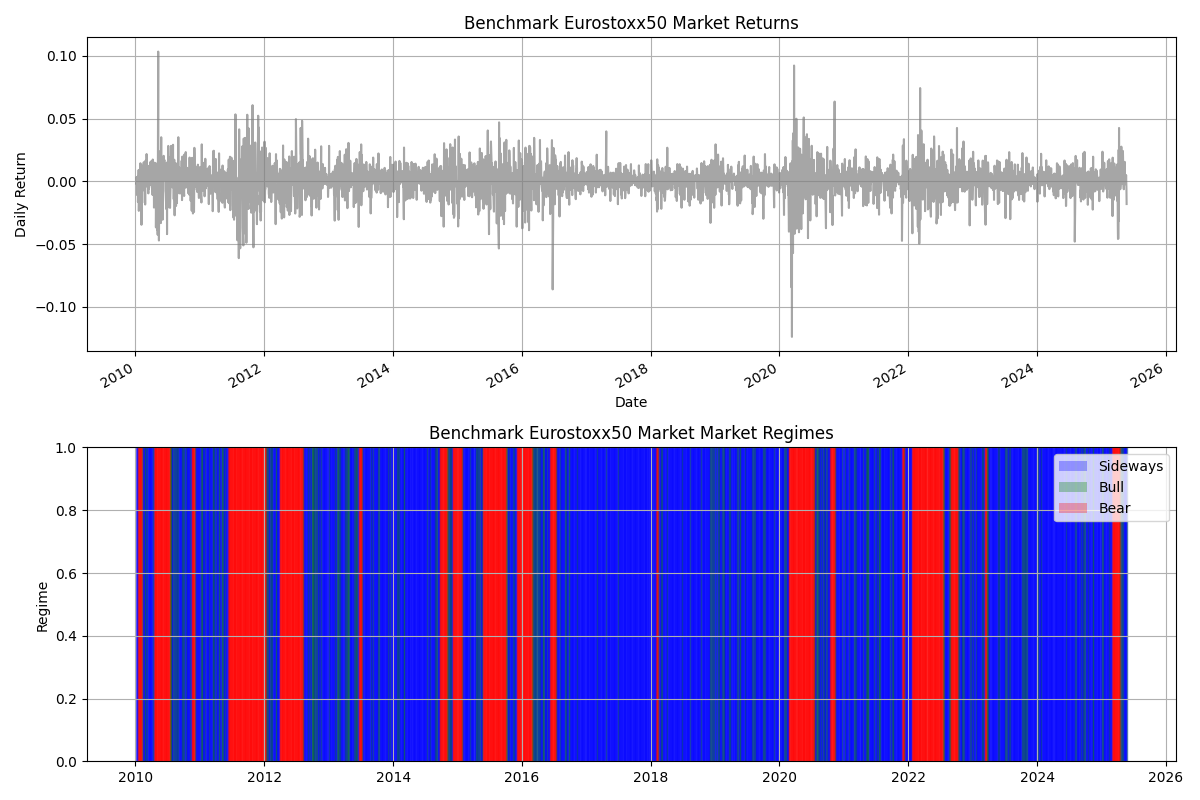


--- benchmark_eurostoxx50_volatility_volatility_regimes.png ---


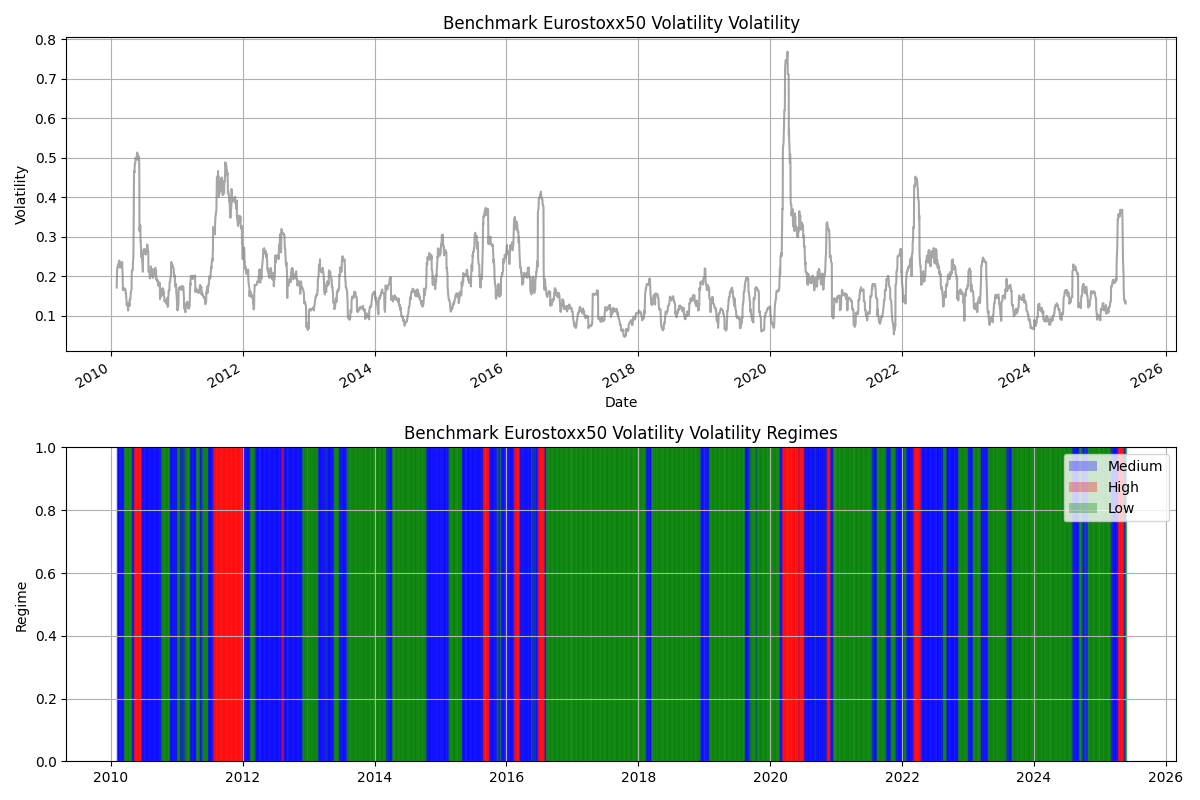


--- portfolio_combined_combined_regimes.png ---


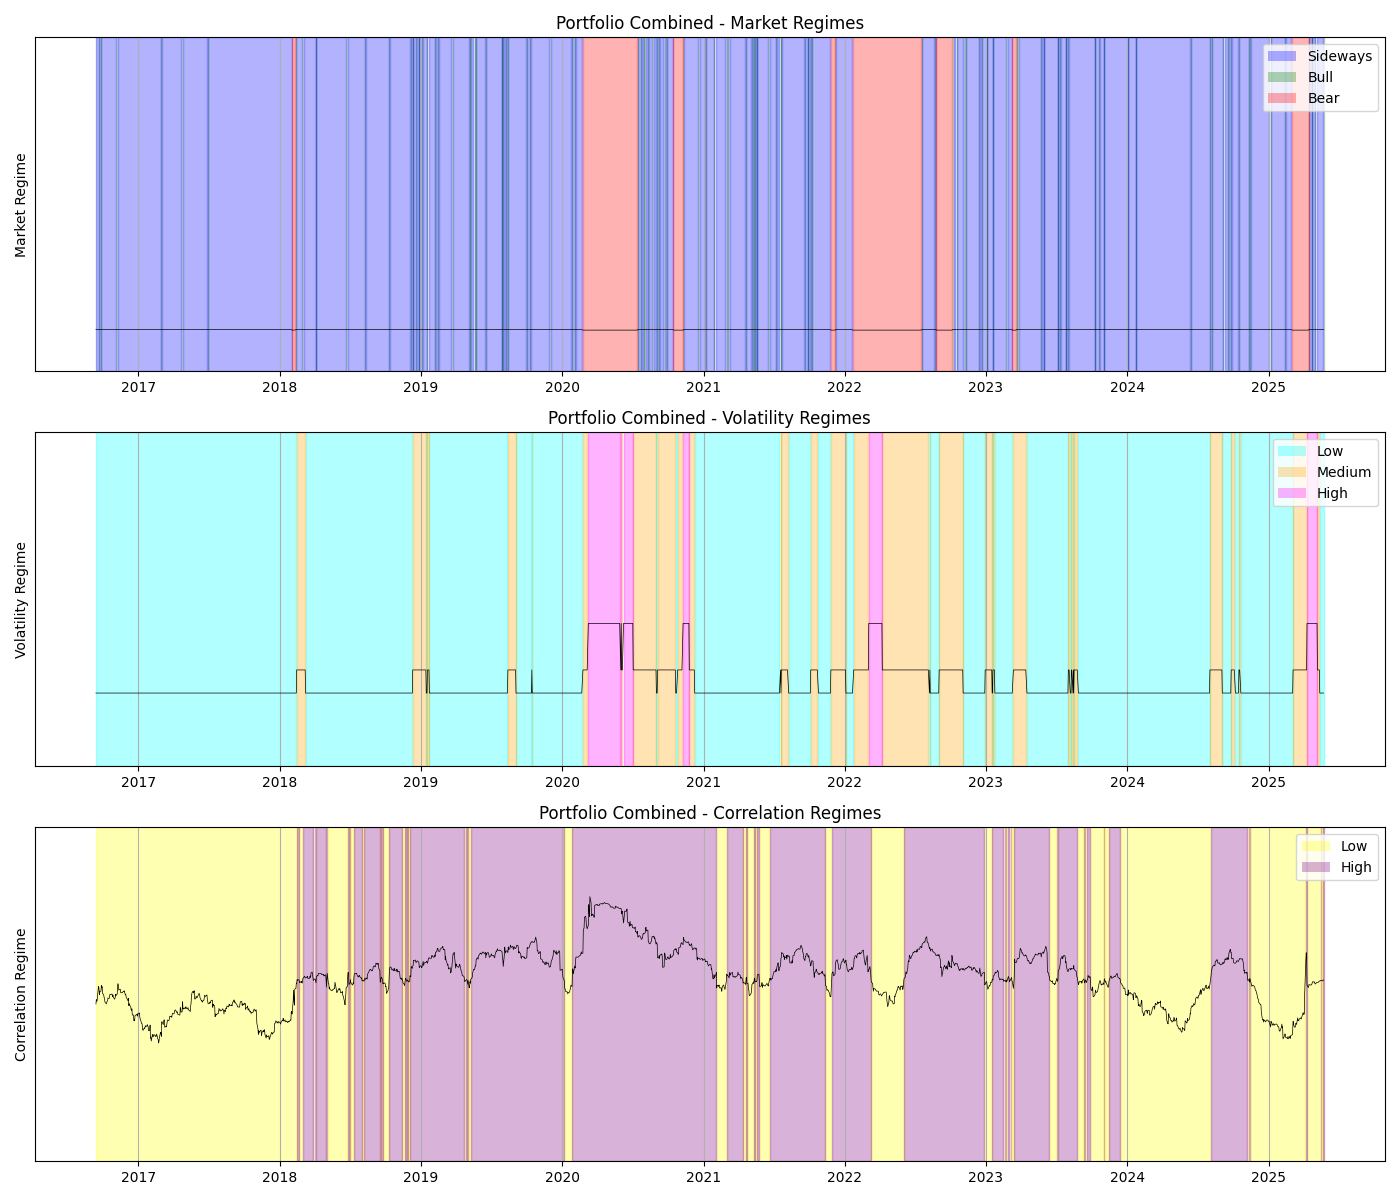


--- portfolio_correlation_correlation_regimes.png ---


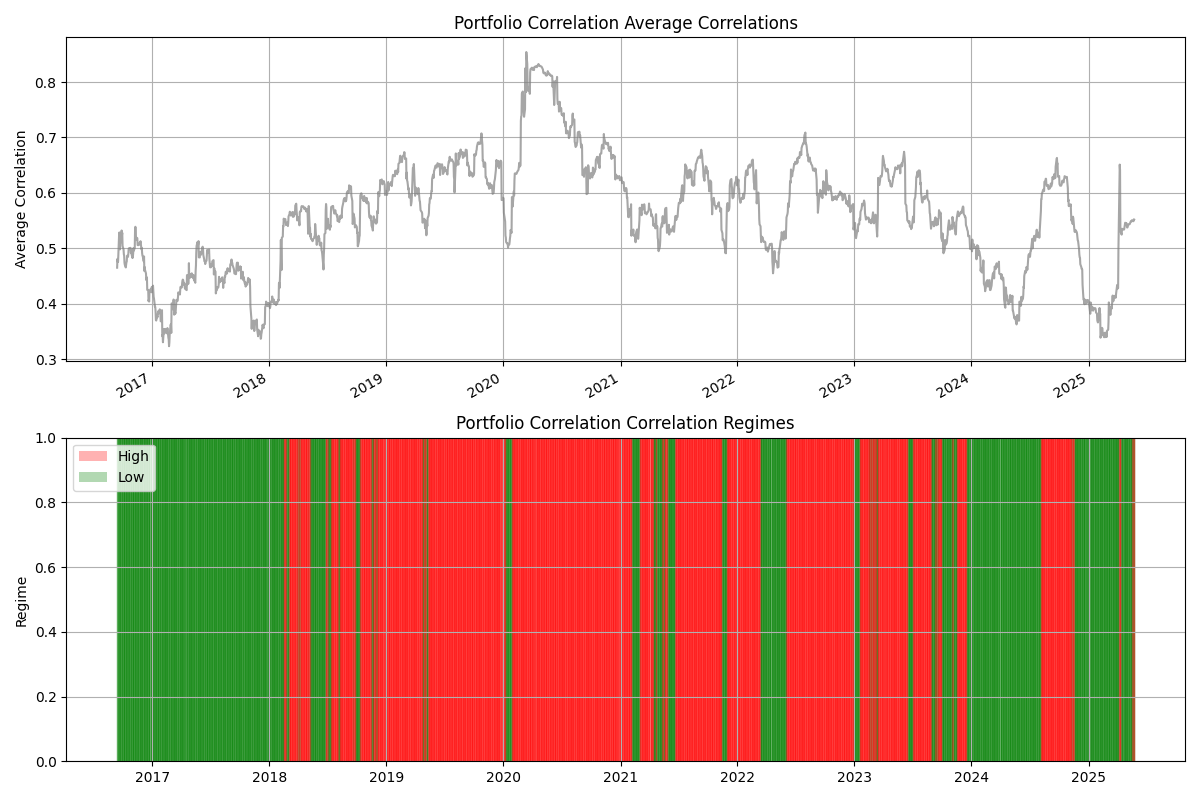

In [19]:
# Display the generated figures
if not figure_files:
    print("No figures to display.")
else:
    for f in figure_files:
        print(f"\n--- {f} ---")
        image_path = os.path.join(FIGURES_DIR, f)
        try:
            display(Image(filename=image_path))
        except FileNotFoundError:
            print(f"Error: Image file not found at {image_path}")
        except Exception as e:
            print(f"Error displaying image {f}: {e}")

## Conclusion

This notebook demonstrated the workflow for detecting market, volatility, and correlation regimes using the provided Python scripts. We executed the data processing and regime detection steps and visualized the resulting plots.

**Important Note:** The results shown here are based on **dummy data** due to limitations in downloading live European asset data via `yfinance`. The detected regimes and plots are illustrative and do not represent actual market conditions. To obtain meaningful results, replace the dummy data in `data/raw/` with actual historical data for valid European tickers.